In [143]:
# Preprocessors
import copy
import os

import cv2

from preprocessing.Preprocessors import *
from preprocessing.Paint_Extractor_Preprocessor import *
from preprocessing.Noise_Extractor_Preprocessor import *
from preprocessing.Color_Preprocessor import *
from preprocessing.Text_Extractor_Preprocessor import *

# Descriptors
from descriptors.Color_Descriptors import *
from descriptors.Text_Descriptors import *
from descriptors.Texture_Descriptors import *
from descriptors.Filtering_Descriptors import *

#CORE
from core.CoreImage import *

#Utils
from utils import utils
from utils.distance_metrics import *

import textdistance


## Auxiliar imports
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import  matplotlib.pyplot as plt

In [144]:
def harmonize_tokens(text):
    final_text = []
    if len(text) > 0:
        for t in text:
            t = t.split(" ")
            for st in t:
                ext = [c for c in st if c.isalpha()]
                ext = "".join(ext)
                if len(ext) > 0:
                    final_text.append(ext)
    final_text = sorted(final_text)
    final_text = " ".join(final_text)

    return final_text

In [145]:
utils.read_author_bbdd("../data/BBDD")
BBDD_AUTHORS = sorted(utils.read_author_bbdd("../data/BBDD"))


In [146]:
with open(str(BBDD_AUTHORS[0]), "r") as f:
    a = (f.readline().strip().split(","))
    if len(a) != 0:
        a = a[0]
        author = (a[1:].split(",")[0]).split(" ")
        print(author)
        harmo_authors = harmonize_tokens(author)
        
    else:
        harmo_authors = "Unkown"

["'Victor", "Perez-Porros'"]


In [147]:
harmo_authors

'PerezPorros Victor'

In [193]:
queries = utils.read_pickle("../data/qsd2_w3/qsd2_w3_processed.pkl")

In [196]:
queries[10][0]._candidates

[24, 45, 155, 90, 91, 101, 182, 252, 262]

['', 'Alfred Dort Figueras', '', 'Alfred Figueras Lort']


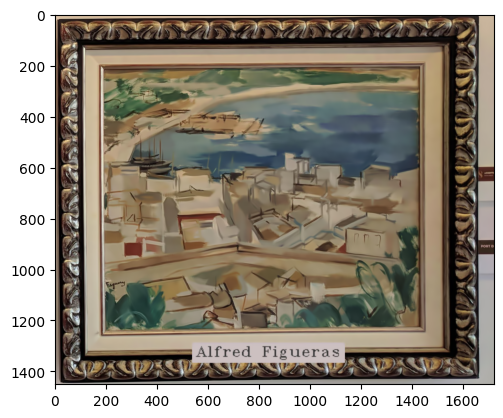

In [249]:
plt.imshow(queries[11][0]._paint)
print(queries[11][0]._text)

In [250]:
authors_BBDD = utils.read_pickle("../data/BBDD/authors.pkl")
authors_BBDD

{'PerezPorros Victor': [0, 134],
 'Demarco Hugo': [1],
 'Unknown': [2,
  9,
  14,
  17,
  18,
  19,
  29,
  33,
  36,
  38,
  49,
  56,
  59,
  61,
  62,
  65,
  66,
  73,
  80,
  85,
  97,
  98,
  105,
  108,
  112,
  114,
  115,
  125,
  126,
  127,
  129,
  138,
  139,
  141,
  144,
  145,
  148,
  152,
  153,
  156,
  159,
  171,
  185,
  186,
  189,
  191,
  195,
  196,
  197,
  205,
  208,
  209,
  213,
  229,
  230,
  253,
  255,
  264,
  268,
  269,
  270,
  278,
  279,
  284],
 'Edvard Munch': [3, 63, 69, 84, 94, 132, 135, 232, 234, 237, 271, 275],
 'Carral Martin': [4, 188],
 'Mario Pasqualotto': [5, 99],
 'Gerard Sala': [6],
 'Hortal Yago': [7],
 'Guinovart Josep': [8, 25, 242],
 'Agusti Puig': [10, 37, 121, 180, 216],
 'Hernandez Joan Pijuan': [11, 93, 190, 207, 238, 280, 285],
 'Gimenez Regina': [12, 200],
 'Pere Santilari': [13, 52, 77, 277],
 'Ginovart Josep': [15],
 'Corneille': [16],
 'Antoni Llena': [20, 204, 236],
 'Cisquella Josep': [21],
 'Cuixart Modest': [22, 92,

In [251]:
comparer_text = queries[11][0]._text

In [252]:
textdistance.jaccard

Jaccard({'qval': 1, 'as_set': False, 'external': True})

In [253]:
decission = []
for possible_auth in set(comparer_text):
    for idx, author in enumerate(authors_BBDD.keys()):
        similarity = textdistance.jaccard(possible_auth, author)
        simliarity = similarity
        
        if similarity > 0.7:
            decission.append((idx, similarity))

decission = sorted(decission, key=lambda x: x[1], reverse=True)

In [254]:
decission

[(28, 0.75), (28, 0.75)]

In [255]:
final_decission = decission[:len(comparer_text)]

In [256]:
final_decission

[(28, 0.75), (28, 0.75)]

In [257]:
list(authors_BBDD.items())[28]

('Alfred Figueras',
 [39,
  51,
  58,
  81,
  82,
  104,
  113,
  130,
  137,
  154,
  160,
  163,
  168,
  170,
  192,
  215,
  225,
  228,
  239,
  248,
  259,
  276])

In [219]:
paint = queries[15][0]._paint

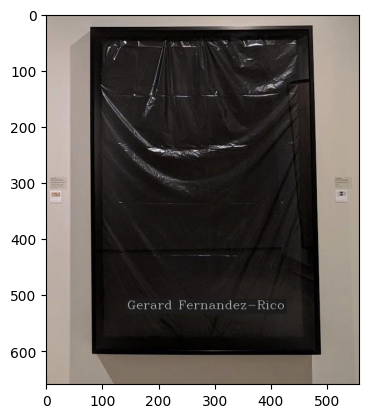

In [220]:
y,x,h,w = (refine_mask(paint)[0])

if not y == x == h == w:
    plt.imshow(paint[y:y+h,x:x+w])
else:
    plt.imshow(paint)


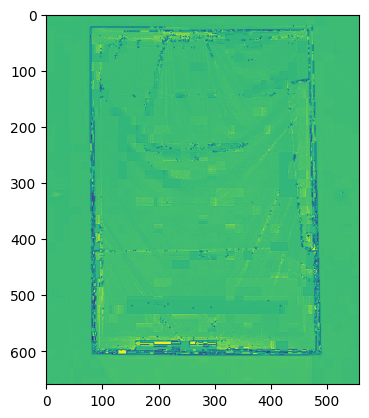

In [221]:
rg_chrom = Color_Preprocessor.convert2rg_chromaticity(paint)
enhanced = ((rg_chrom + utils.sharpening(rg_chrom)) * 255).astype("uint8")
enhanced = (enhanced[:, :, 0] + enhanced[:, :, 1]) // 2
plt.imshow(enhanced)

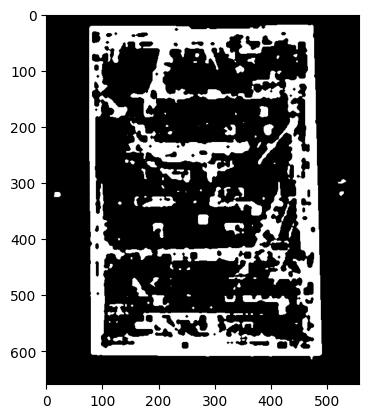

In [222]:
## applying the derivates (sobel)
edge = utils.Sobel_magnitude(enhanced, x_importance=6, y_importance=6)

thr = filters.threshold_otsu(edge)
edge = (edge > thr).astype(np.uint8)
edge = utils.apply_closing(edge, (5,5))
edge = cv2.medianBlur(edge, 5)
#edge = utils.apply_erode(edge, (3,3))
plt.imshow(edge, cmap="gray")

In [223]:
## Apply hough transform
mask = np.zeros_like(edge)
min_shape = min(edge.shape[0], edge.shape[1])
max_line_gap = int(min_shape * 0.02)
h_, w_ = edge.shape
votes_min_l = int(min(h_ * 0.05, w_ * 0.05))

linesP = cv2.HoughLinesP(edge, 1, np.pi / 180, votes_min_l, minLineLength=votes_min_l, maxLineGap=max_line_gap)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(mask, (l[0], l[1]), (l[2], l[3]), 255, 3, cv2.LINE_AA)



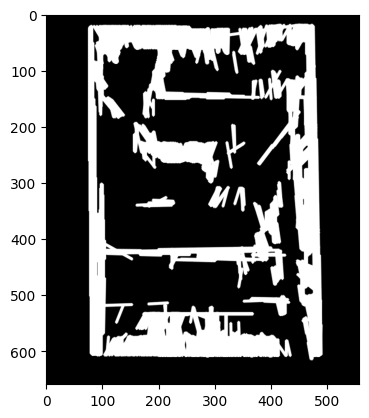

In [224]:
plt.imshow(mask, cmap="gray")

In [225]:
# Getting the contour
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
decission = []
heigh_im, width_im = edge.shape


## Getting the final bbox
new_mask = np.zeros_like(edge)
absolut_area = new_mask.shape[0] * new_mask.shape[1]

for contour in contours:
    convexHull = cv2.convexHull(contour)

    perimeter = cv2.arcLength(convexHull, True)
    x, y, w, h = cv2.boundingRect(convexHull)
    aspect_ratio = w / h
    area = w * h
    proportion_height = h / heigh_im
    proportion_width = w / width_im

    if (proportion_height > 0.15) and (proportion_width > 0.15) and width_im and (area > absolut_area * 0.7):
        decission.append(([y, x, h, w], perimeter, area, aspect_ratio))

decission = sorted(decission, key=lambda x: x[2], reverse=True)
decission = utils.non_maximun_supression(decission)

if len(decission) != 0:
    new_bbox = decission[0][0]
    y, x, h, w = new_bbox
    new_mask[y:y + h, x:x + w] = 1

else:
    new_bbox = [0,0,0,0]
    new_mask = np.ones_like(new_mask)

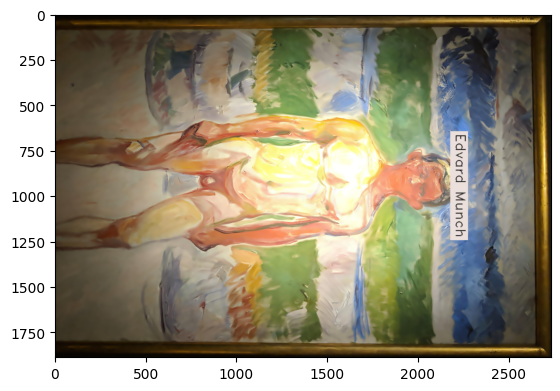

In [164]:
plt.imshow(paint[y:y+h,x:x+w])